# We Rate Dogs Analysis
Your goal: wrangle WeRateDogs Twitter data to create interesting and trustworthy analyses and visualizations. The Twitter archive is great, but it only contains very basic tweet information. Additional gathering, then assessing and cleaning is required for "Wow!"-worthy analyses and visualizations.

# Import Necessary Libraries


In [64]:
!pip install --upgrade tweepy



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [65]:
# Import necessary libraries
import os
import requests
import tweepy
import configparser
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_colwidth', 1000)

# Data Wrangling
In this phase, the data is gathered, assessed and cleaned to aid in the exploratory data analysis.

## Gather Data
In this phase, we obtain the data.

**Get existing data**

In [66]:
# import current data
df = pd.read_csv('/content/twitter-archive-enhanced.csv')
df.head()


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Phineas. He's a mystical boy. Only ever appears in the hole of a donut. 13/10 https://t.co/MgUWQ76dJU,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643555336193/photo/1,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Tilly. She's just checking pup on you. Hopes you're doing ok. If not, she's available for pats, snugs, boops, the whole bit. 13/10 https://t.co/0Xxu71qeIV",NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421306343426/photo/1,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Archie. He is a rare Norwegian Pouncing Corgo. Lives in the tall grass. You never know when one may strike. 12/10 https://t.co/wUnZnhtVJB,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181378084864/photo/1,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Darla. She commenced a snooze mid meal. 13/10 happens to the best of us https://t.co/tD36da7qLQ,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557279858688/photo/1,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","This is Franklin. He would like you to stop calling him ""cute."" He is a very fierce shark and should be respected as such. 12/10 #BarkWeek https://t.co/AtUZn91f7f",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/891327558926688256/photo/1,https://twitter.com/dog_rates/status/891327558926688256/photo/1",12,10,Franklin,None,None,None,None


**Get tweet image predictions**

In [67]:
# Image predictions
images_url = ' https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
file_name = 'image_predictions.tsv'

# Get response
response = requests.get(images_url)

# Save data
with open(file_name, 'w') as f:
  f.write(response.text)
  
# Read data
images_df = pd.read_csv(response.url, sep='\t')
images_df.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


**Get tweet data from tweepy**

In [ ]:
# Set Configurations

# Instantiate configparser
config = configparser.ConfigParser()
config.read('/content/config.ini')

# Read api key and token from config file
api_key = config['Twitter']['API_KEY']
api_key_secret = config['Twitter']['API_KEY_SECRET']
access_token = config['Twitter']['ACCESS_TOKEN']
access_token_secret = config['Twitter']['ACCESS_TOKEN_SECRET']

# Authentication
auth = tweepy.OAuthHandler(api_key, api_key_secret)
auth.set_access_token(access_token, access_token_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)


In [ ]:
# Function to get tweet data
def get_tweet_data(df, tweet_id_column):
  tweet_ids = df[tweet_id_column].values
  favorites = []
  retweets = []
  for tweet_id in tweet_ids:
    try:
      retweets.append(api.get_status(id=tweet_id, tweet_mode='extended').retweet_count)
      favorites.append(api.get_status(id=tweet_id, tweet_mode='extended').favorite_count)
    except:
      retweets.append(np.nan)
      favorites.append(np.nan)

  
  

  return favorites, retweets





In [ ]:
# Get favorites and retweets
favs, retweets = get_tweet_data(df, 'tweet_id')

In [ ]:
# Append them to a dataframe
favs_rets_df = pd.DataFrame({'tweet_id': df['tweet_id'].values,
              'favorites_count':favs,
              'retweets_count': retweets})

In [ ]:
# Save to tweet_json.txt file
favs_rets_df.to_json('tweet_json.txt', orient='columns')

In [68]:
# Read data from json_file
favs_rets_df = pd.read_json('/content/tweet_json.txt', orient='columns')

**Combine datasets**

In [69]:
# Concatenate reweet counts and fav counts to df
updated_df = df.merge(favs_rets_df, on='tweet_id')

In [70]:
# Concatenate images_df and updated_df
updated_df = pd.merge(updated_df , images_df , on= "tweet_id" , how="left") 

## Assess Data

**Assess existing data and Image data**

In [71]:
# View info
updated_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 2355
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [72]:
# Get missing value columns
missing = [column for column in updated_df.columns if updated_df[column].isnull().sum()>0]
missing

['in_reply_to_status_id',
 'in_reply_to_user_id',
 'retweeted_status_id',
 'retweeted_status_user_id',
 'retweeted_status_timestamp',
 'expanded_urls',
 'favorites_count',
 'retweets_count',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

There are missing values in the following columns:
`in_reply_to_status_id`,
 `in_reply_to_user_id`,
 `retweeted_status_id`,
 `retweeted_status_user_id`,
 `retweeted_status_timestamp`,
 `expanded_urls`,
 `favorites_count`,
 `retweets_count`,`jpg_url`,
 `img_num`,
 `p1`,
 `p1_conf`,
 `p1_dog`,
 `p2`,
 `p2_conf`,
 `p2_dog`,
 `p3`,
 `p3_conf`,
 `p3_dog`

In [73]:
# Check for duplicates
updated_df.duplicated().sum()

0

There are no duplicates

In [74]:
# View statistics
updated_df.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator,favorites_count,retweets_count,img_num,p1_conf,p2_conf,p3_conf
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000,2327.000000,2327.000000,2075.000000,2075.000000,2.075000e+03,2.075000e+03
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433,7031.703051,2461.993554,1.203855,0.594548,1.345886e-01,6.032417e-02
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237,10925.613904,4169.607446,0.561875,0.271174,1.006657e-01,5.090593e-02
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000,0.000000,1.000000,1.000000,0.044333,1.011300e-08,1.740170e-10
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000,1221.500000,493.000000,1.000000,0.364412,5.388625e-02,1.622240e-02
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000,3041.000000,1147.000000,1.000000,0.588230,1.181810e-01,4.944380e-02
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000,8571.500000,2848.000000,1.000000,0.843855,1.955655e-01,9.180755e-02
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000,144365.000000,70452.000000,4.000000,1.000000,4.880140e-01,2.734190e-01


In [75]:
# View sample of data
updated_df.sample(10)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1116,732585889486888962,NaN,NaN,2016-05-17 14:57:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","When your teacher agreed on 10,000 RTs and no final but after 24 hours you only have 37... 10/10 https://t.co/sVnJfWVjUp",NaN,NaN,NaN,"https://twitter.com/dog_rates/status/732585889486888962/photo/1,https://twitter.com/dog_rates/status/732585889486888962/photo/1",...,2.0,Staffordshire_bullterrier,0.843359,True,American_Staffordshire_terrier,0.028290,True,miniature_pinscher,0.016793,True
2322,666430724426358785,NaN,NaN,2015-11-17 01:40:41 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Oh boy what a pup! Sunglasses take this one to the next level. Weirdly folds front legs. Pretty big. 6/10 https://t.co/yECbFrSArM,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666430724426358785/photo/1,...,1.0,llama,0.505184,False,Irish_terrier,0.104109,True,dingo,0.062071,False
1332,705475953783398401,NaN,NaN,2016-03-03 19:32:29 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to Zara. She found a sandal and couldn't be happier. 12/10 great work https://t.co/zQUuVu812n,NaN,NaN,NaN,"https://twitter.com/dog_rates/status/705475953783398401/photo/1,https://twitter.com/dog_rates/status/705475953783398401/photo/1",...,1.0,golden_retriever,0.908784,True,Labrador_retriever,0.030361,True,tennis_ball,0.004996,False
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Jax. He enjoys ice cream so much he gets nervous around it. 13/10 help Jax enjoy more things by clicking below\n\nhttps://t.co/Zr4hWfAs1H https://t.co/tVJBRMnhxl,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,https://twitter.com/dog_rates/status/890971913173991426/photo/1",...,1.0,Appenzeller,0.341703,True,Border_collie,0.199287,True,ice_lolly,0.193548,False
67,879376492567855104,NaN,NaN,2017-06-26 16:31:08 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Jack AKA Stephen Furry. You're not scoring on him. Unless he slips down the slide. 12/10 would happily get blocked by https://t.co/0gOi601EAa,NaN,NaN,NaN,https://twitter.com/dog_rates/status/879376492567855104/photo/1,...,1.0,tricycle,0.663601,False,Labrador_retriever,0.033496,True,Pembroke,0.018827,True
1089,737800304142471168,NaN,NaN,2016-06-01 00:17:54 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bella. She's ubering home after a few too many drinks. 10/10 socially conscious af https://t.co/KxkOgq80Xj,NaN,NaN,NaN,https://twitter.com/dog_rates/status/737800304142471168/photo/1,...,1.0,malamute,0.374682,True,Norwegian_elkhound,0.334853,True,limousine,0.068173,False
1190,718234618122661888,NaN,NaN,2016-04-08 00:30:51 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Suki. She was born with a blurry tail (unfortunate). Next level tongue tho. 11/10 nifty hardwood https://t.co/05S8oYztgb,NaN,NaN,NaN,https://twitter.com/dog_rates/status/718234618122661888/photo/1,...,1.0,malamute,0.370152,True,Siberian_husky,0.356398,True,Eskimo_dog,0.271042,True
431,820837357901512704,NaN,NaN,2017-01-16 03:37:31 +0000,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",RT @dog_rates: This is Finn. He's wondering if you come here often. Fr*ckin flirtatious af. 12/10 would give number to https://t.co/ii5eNX5…,8.192277e+17,4.196984e+09,2017-01-11 17:01:16 +0000,https://twitter.com/dog_rates/status/819227688460238848/photo/1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
378,827933404142436356,

From this, it is visible that there are some issues:

**Tidiness Issues**
- `rating_numerator` and `rating_denominator` are different columns representing a similar quality.
- The `doggo`,`floofer`,`pupper` and `puppo` are different columns representing a similar dog quality.

**Quality Issues**
- The timestamp variables have an object datatype.
- The `in_reply_to_status_id`, `in_reply_to_user_id`, `favorite_counts` and `retweet_counts` variables are floats.
- There are missing values in the following columns:
`in_reply_to_status_id`,
 `in_reply_to_user_id`,
 `retweeted_status_id`,
 `retweeted_status_user_id`,
 `retweeted_status_timestamp`,
 `expanded_urls`,
 `favorites_count`,
 `retweets_count`,`jpg_url`,
 `img_num`,
 `p1`,
 `p1_conf`,
 `p1_dog`,
 `p2`,
 `p2_conf`,
 `p2_dog`,
 `p3`,
 `p3_conf`,
 `p3_dog`.
- Redundancy in the columns `in_reply_to_status_id` and `tweet_id`.
- `rating_denominator` has value more than 10.
- Presence of columns with data on retweeted.
- `fav_rets_df` had duplicate id.
- Some images are not classified as dogs in all three categories.
- `fav_rets_df` id name not consistent with tweet_id column name that is common for the other datasets.

## Clean Data

In [76]:
# Make data copy
to_clean_df = updated_df.copy()

### Quality Issues
Fix quality issues

#### Inconsistency in fav_rets_df
The inconsistency in the favs_rets_df was solved in the **gathering data** phase.

#### Missing Values

**Define**
- Delete any column that has more than 70% missing data.
- Drop any other observations with missing values. 


**Code**

In [77]:
# Drop any column that has missing values that are more than 70%

## Get columns
to_drop = [column for column in to_clean_df.columns if to_clean_df[column].isnull().sum()/len(to_clean_df) > 0.7 ]

## Drop them
to_clean_df.drop(to_drop, axis=1, inplace=True)

In [78]:
# Drop missing observations

to_clean_df.dropna(axis=0, how='any', inplace=True)
to_clean_df.reset_index(drop=True, inplace=True)

**Test**

In [79]:
# Check for missing values
to_clean_df.isnull().sum()

tweet_id              0
timestamp             0
source                0
text                  0
expanded_urls         0
rating_numerator      0
rating_denominator    0
name                  0
doggo                 0
floofer               0
pupper                0
puppo                 0
favorites_count       0
retweets_count        0
jpg_url               0
img_num               0
p1                    0
p1_conf               0
p1_dog                0
p2                    0
p2_conf               0
p2_dog                0
p3                    0
p3_conf               0
p3_dog                0
dtype: int64

The missing values have been dealt with. Observations with retweeted data have also been dealt with via this operation.

#### Datatype issues


**Define**
- Convert timestamp to datetime
- Convert retweet_count and favorites_count to integer.

**Code**

In [80]:
# Convert timestamp to datetime
to_clean_df['timestamp'] = pd.to_datetime(to_clean_df['timestamp'])

In [81]:
# Convert retweet_count and favorite_count to integers
to_clean_df['favorites_count'] = to_clean_df['favorites_count'].astype(int)
to_clean_df['retweets_count'] = to_clean_df['retweets_count'].astype(int)

**Test**

In [82]:
to_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2057 entries, 0 to 2056
Data columns (total 25 columns):
 #   Column              Non-Null Count  Dtype              
---  ------              --------------  -----              
 0   tweet_id            2057 non-null   int64              
 1   timestamp           2057 non-null   datetime64[ns, UTC]
 2   source              2057 non-null   object             
 3   text                2057 non-null   object             
 4   expanded_urls       2057 non-null   object             
 5   rating_numerator    2057 non-null   int64              
 6   rating_denominator  2057 non-null   int64              
 7   name                2057 non-null   object             
 8   doggo               2057 non-null   object             
 9   floofer             2057 non-null   object             
 10  pupper              2057 non-null   object             
 11  puppo               2057 non-null   object             
 12  favorites_count     2057 non-null 

The datatypes have been correctly changed.

#### Value Issues

**Define**
- Investigate all values in denominator that are less than 10.
- Drop values in denominator greater than 10.
- Combine the two ratings into one column called `rating_out_of_ten`.

**Code**

In [83]:
# Investigate observations with rating denominator more than 10
more_than_10 = to_clean_df.query('rating_denominator != 10')
more_than_10

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,...,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
335,820690176645140481,2017-01-15 17:52:40+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",The floofs have been released I repeat the floofs have been released. 84/70 https://t.co/NIYC820tmd,"https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1,https://twitter.com/dog_rates/status/820690176645140481/photo/1",84,70,None,None,None,...,2.0,West_Highland_white_terrier,0.872064,True,kuvasz,0.059526,True,Samoyed,0.037400,True
405,810984652412424192,2016-12-19 23:06:23+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Meet Sam. She smiles 24/7 &amp; secretly aspires to be a reindeer. \nKeep Sam smiling by clicking and sharing this link:\nhttps://t.co/98tB8y7y7t https://t.co/LouL5vdvxx,"https://www.gofundme.com/sams-smile,https://twitter.com/dog_rates/status/810984652412424192/photo/1",24,7,Sam,None,None,...,1.0,golden_retriever,0.871342,True,Tibetan_mastiff,0.036708,True,Labrador_retriever,0.025823,True
720,758467244762497024,2016-07-28 01:00:57+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Why does this never happen at my front door... 165/150 https://t.co/HmwrdfEfUE,https://twitter.com/dog_rates/status/758467244762497024/video/1,165,150,None,None,None,...,1.0,Labrador_retriever,0.436377,True,Chihuahua,0.113956,True,American_Staffordshire_terrier,0.099689,True
861,740373189193256964,2016-06-08 02:41:38+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>","After so many requests, this is Bretagne. She was the last surviving 9/11 search dog, and our second ever 14/10. RIP https://t.co/XAVDNDaVgQ","https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1,https://twitter.com/dog_rates/status/740373189193256964/photo/1",9,11,None,None,None,...,3.0,golden_retriever,0.807644,True,kuvasz,0.101286,True,Labrador_retriever,0.023785,True
909,731156023742988288,2016-05-13 16:15:54+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Say hello to this unbelievably well behaved squad of doggos. 204/170 would try to pet all at once https://t.co/yGQI3He3xv,https://twitter.com/dog_rates/status/731156023742988288/photo/1,204,170,this,None,None,...,1.0,lakeside,0.501767,False,breakwater,0.051351,False,king_penguin,0.049444,False
952,722974582966214656,2016-04-21 02:25:47+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy 4/20 from the squad! 13/10 for all https://t.co/eV1diwds8a,https://twitter.com/dog_rates/status/722974582966214656/photo/1,4,20,None,None,None,...,1.0,Great_Dane,0.246762,True,Greater_Swiss_Mountain_dog,0.126131,True,Weimaraner,0.085297,True
986,716439118184652801,2016-04-03 01:36:11+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",This is Bluebert. He just saw that both #FinalFur match ups are split 50/50. Amazed af. 11/10 https://t.co/Kky1DPG4iq,https://twitter.com/dog_rates/status/716439118184652801/photo/1,50,50,Bluebert,None,None,...,1.0,Siberian_husky,0.396495,True,malamute,0.317053,True,Eskimo_dog,0.273419,True
1007,713900603437621249,2016-03-27 01:29:02+00:00,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",Happy Saturday here's 9 puppers on a bench. 99/90 good work everybody https://t.co/mpvaVxKmc1,https://twitter.com/dog_rates/status/713900603437621249/photo/1,99,90,None,None,None,...,1.0,golden_retriever,0.371816,True,cocker_spaniel,0.177413,True,Irish_setter,0.092725,True
1032,710658690886586372,2016

In [84]:
# Drop these ratings
to_clean_df = to_clean_df.query('rating_denominator == 10')

In [85]:
# Drop rating denominator
to_clean_df.drop('rating_denominator', axis=1, inplace=True)

In [86]:
# Rename rating_numerator column to rating
to_clean_df.rename(columns={'rating_numerator': 'rating_out_of_ten'}, inplace=True)

**Test**

In [87]:
# Check of ratings denominator is there
to_clean_df.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_out_of_ten', 'name', 'doggo', 'floofer', 'pupper', 'puppo',
       'favorites_count', 'retweets_count', 'jpg_url', 'img_num', 'p1',
       'p1_conf', 'p1_dog', 'p2', 'p2_conf', 'p2_dog', 'p3', 'p3_conf',
       'p3_dog'],
      dtype='object')

#### Dog Predictions being all False

**Define**
- Delete all observations with dog predictions being all false.

**Code**

In [88]:
# Delete observations
indices = to_clean_df.loc[(to_clean_df['p1_dog'] == False) & (to_clean_df['p2_dog'] == False) & (to_clean_df['p3_dog'] == False)].index
to_clean_df.drop(indices, axis=0, inplace=True)

**Test**

In [89]:
# Check whether they exist
assert len(to_clean_df.loc[(to_clean_df['p1_dog'] == False) & (to_clean_df['p2_dog'] == False) & (to_clean_df['p3_dog'] == False)]) == 0

### Tidiness Issues

**Define**
- Organize `doggo`, `floofer`,`pupper` & `puppo` into a column called `dog_stage`.
-Replace nans with `undefined`

**Code**

In [90]:
# Move names to one column
to_clean_df.loc[to_clean_df['floofer']=='floofer', 'dog_stage'] = 'floofer'
to_clean_df.loc[to_clean_df['doggo']=='doggo', 'dog_stage'] = 'doggo'
to_clean_df.loc[to_clean_df['pupper']=='pupper', 'dog_stage'] = 'pupper'
to_clean_df.loc[to_clean_df['puppo']=='puppo', 'dog_stage'] = 'puppo'

# Fill the missing values with undefined
to_clean_df['dog_stage'].fillna('undefined', inplace=True)

# Drop the redundant columns
to_clean_df.drop(['floofer', 'doggo','pupper', 'puppo'], axis=1, inplace=True)


**Test**

In [91]:
# Check for nulls
to_clean_df['dog_stage'].isnull().sum()

0

In [92]:
 # Check for correct columns
 to_clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1719 entries, 1 to 2056
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype              
---  ------             --------------  -----              
 0   tweet_id           1719 non-null   int64              
 1   timestamp          1719 non-null   datetime64[ns, UTC]
 2   source             1719 non-null   object             
 3   text               1719 non-null   object             
 4   expanded_urls      1719 non-null   object             
 5   rating_out_of_ten  1719 non-null   int64              
 6   name               1719 non-null   object             
 7   favorites_count    1719 non-null   int64              
 8   retweets_count     1719 non-null   int64              
 9   jpg_url            1719 non-null   object             
 10  img_num            1719 non-null   float64            
 11  p1                 1719 non-null   object             
 12  p1_conf            1719 non-null   float64      

In [93]:
# Check dog stage value_counts
to_clean_df['dog_stage'].value_counts()

undefined    1451
pupper        182
doggo          56
puppo          23
floofer         7
Name: dog_stage, dtype: int64

The data is now clean and tidy and can be stored

### Store Data

In [94]:
# Reset index
to_clean_df.reset_index(drop=True, inplace=True)

In [95]:
# Store the data
to_clean_df.to_csv('twitter_archive_master.csv', index=False)

# Exploratory Data Analysis

**What is the relationship between retweeted_count, favorites_count and rating?**

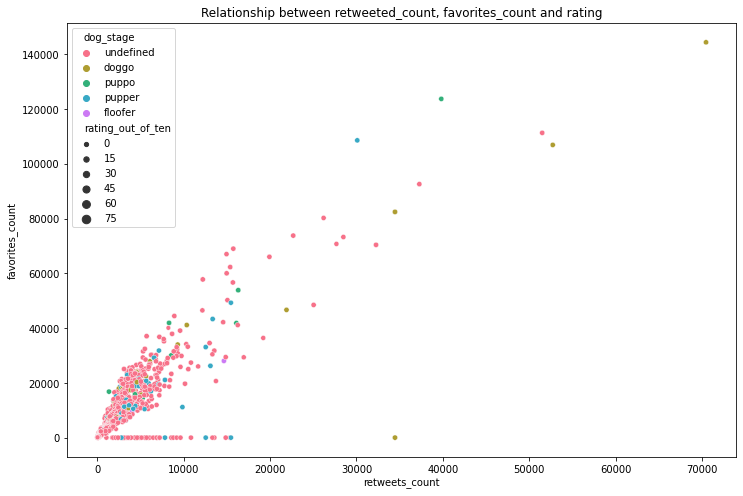

In [97]:
# Plot
plt.figure(figsize=(12, 8))
sns.scatterplot(x='retweets_count', y='favorites_count',
                size='rating_out_of_ten', hue='dog_stage',
                data=to_clean_df, palette='husl');
plt.title('Relationship between retweeted_count, favorites_count and rating');

It seems rating didn't have a huge impact on the favorites and retweets count. However, the retweets counts and favorite counts are highly correlated. Meaning, one was likely to like and retweet a tweet about a dog, if they liked the dog.

**What is the most liked dog stage?**

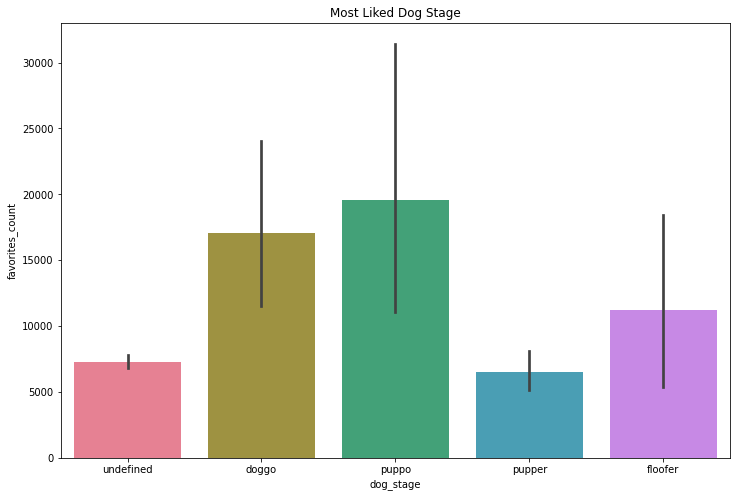

In [98]:
# Plot
plt.figure(figsize=(12, 8))
sns.barplot(x='dog_stage', y='favorites_count',
            data=to_clean_df, palette='husl');
plt.title('Most Liked Dog Stage');

The defined dog stages were liked more compared to the undefined dog stages with puppies gathering the most likes.

**Insights**
- When one likes an image, they are highly likely to retweet the image too.
- The most liked dog stage is the `puppo` stage.
- The `undefined` and `pupper` dog stages were the least liked.